## 전체 기본 환경 설정

In [1]:
%pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Note: you may need to restart the kernel to use updated packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
from scipy import stats

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.impute import SimpleImputer


import eli5
from eli5.sklearn import PermutationImportance

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (/opt/conda/lib/python3.10/site-packages/sklearn/utils/metaestimators.py)

## 데이터 불러오기

In [3]:
train = pd.read_csv('/data/ephemeral/home/code/train.csv')
test = pd.read_csv('/data/ephemeral/home/code/test.csv')
subway = pd.read_csv('/data/ephemeral/home/code/subway_feature.csv')
bus = pd.read_csv('/data/ephemeral/home/code/bus_feature.csv')
GIS = pd.read_csv('/data/ephemeral/home/code/GIS_output.csv')

In [4]:
# Train data와 Test data shape
print('Train data shape : ', train.shape, 
      '\nTest data shape : ', test.shape, 
      '\nTrain_GIS data shape : ', GIS.shape,
      '\nBus data shape : ', bus.shape,
      '\nSubway data shape : ', subway.shape)

Train data shape :  (1118822, 52) 
Test data shape :  (9272, 51) 
Train_GIS data shape :  (695900, 30) 
Bus data shape :  (12584, 6) 
Subway data shape :  (768, 5)


In [5]:
# Train과 Test data를 살펴보겠습니다.
display(train.head(1))
display(test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.
display(GIS.head(1))
display(bus.head(1))
display(subway.head(1))


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


,원천도형ID,GIS건물통합식별번호,고유번호,법정동코드,법정동명,지번,특수지코드,특수지구분명,건축물용도코드,건축물용도명,...,위반건축물여부,참조체계연계키,데이터기준일자,원천시도시군구코드,건물명,건물동명,지상층_수,지하층_수,데이터생성변경일자,geometry
0,32,1991201839054527769900000000,1111017500107040000,1111017500,서울특별시 종로구 숭인동,704,1,일반,01000,단독주택,...,N,B00100000000T30Z9,2024-11-01,11110,NaN,NaN,3.0,0.0,2017-05-30,POLYGON ((201913.63771092566 553085.3228524396...


,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로


,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877


## Train/Test 구분 및 합치기

In [6]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
train['is_test'] = 0
test['is_test'] = 1

In [7]:
dt_concat = pd.concat([train, test])     # 하나의 데이터로 만들어줍니다.

In [8]:
dt_concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

## Data 전처리

1. [기본 환경 설정]
2. [데이터 불러오기]
3. [Train/Test 구분 및 합치기
    - dt_concat

4. [dt_concat 기본 전처리]
    1. 컬럼이름 변경 또는 변수 분할
        - 컬럼 이름 변경 
        - 변수 분할
            - 계약년월 split : 계약년, 계약월
        - 시군구 split : 시, 구, 동
    2. 각 벌럼펼 ' ', '-', 0 등 의미없는 값 결측치 처리
    3. 결측치 비율 확인
    4. 피쳐 드랍
        - 1,000,000 이상 결측치 보유 피쳐 드랍  (dt_concat_select)
        - 본번, 부번은 str으로 변환
        - 중복 데이터 제거
        - continuous/categorical 변수 구분
        [드랍 피쳐 결정]
        - '전화번호', '팩스번호', 'k-사용검사일-사용승인일', '수정일자', '고용보험관리번호', '청소비관리형태','단지승인일'
    

5. [파생변수 생성]
    - '구': tier1,2,3
    - '동': tier1,2,3,4
    - 건축년도: new, mid, old, vold

6. [상관관계 화인]

7. [변수 보간]
    1.  train data 처리
        - train_dt2, test_dt2 생성 (is_test 컬럼 추가)
        - continuous/categorical 변수 구분
    2. 수치형 변수 보간
        - 소수의 null값 보유 row 제거 : 아파트명, 번지
        - 그룹화 선형회귀 모델 (데이터 : 그룹화 기준변수)
            - 전체세대수 : 아파트명, 동
            - 전체동수 : 아파트명, 동
            - 주거전용면적 : 아파트명, 건축년도, 전용면적
            - 연면적 : 아파트명, 건축년도, 전용면적
            - 주차대수 : 전체세대수, 전용면적
            - 전용면적<60, 전용면적60~85, 전용면적85~135 : 아파트명, 주거전용면적, 전용면적
        - 주차대수 binning

* 관리비부과면적, 좌표X, 좌표Y, 건축면적, 단지신청일 제거

    3. 범주형 변수 보강
        - 최빈값(mode)
            - 세대타입, 관리방식, 경비비관리형태, 세대전기계약방법, 기타/의무/임대/임의, 사용허가여부, 관리비 업로드, 
        - 조건부 최빈값(conditional mode)
            - 단지분류(전체동수, 주차대수)
            - 복도유형(아파트명, 건축년도)
            - 난방방식(아파트명, 건축년도, 전용면적)

8. [Encoding]
    - one-hot encoding: '사용허가여부', '시'
        - label encoding: '단지분류', '세대타입', '복도유형', '난방방식', '경비비관리형태', '세대전기계약방식', '관리비 업로드', '기타/의무/임대/임의=1/2/3/4', '주차대수'
        - frequency encoding: '아파트명','건설사', '구', '동', '계약년', '계약월'
        - target encoding : 


9. [함수변환]
    - 우선은 log 변환 적용
    - 로그변환
    - 제곱근변환

### dt_concat 전처리

#### 컬럼 이름 변경 또는 변수 분할

In [9]:
# 컬럼 이름 변경
dt_concat = dt_concat.rename(columns={'전용면적(㎡)':'전용면적',
                                'k-단지분류(아파트,주상복합등등)':'단지분류', 
                                'k-전화번호':'전화번호', 
                                'k-팩스번호':'팩스번호',
                                'k-세대타입(분양형태)':'세대타입',
                                'k-관리방식':'관리방식',
                                'k-복도유형':'복도유형', 
                                'k-난방방식':'난방방식',
                                'k-전체동수':'전체동수', 
                                'k-전체세대수':'전체세대수',
                                'k-건설사(시공사)':'건설사',
                                'k-시행사':'시행사',
                                'k-연면적':'연면적',
                                'k-주거전용면적':'주거전용면적',
                                'k-관리비부과면적':'관리비부과면적',
                                'k-전용면적별세대현황(60㎡이하)':'전용면적<60',
                                'k-전용면적별세대현황(60㎡~85㎡이하)':'전용면적60~85',
                                'k-85㎡~135㎡이하':'전용면적85~135',
                                'k-135㎡초과':'전용면적>135', 
                                'k-홈페이지':'홈페이지',
                                'k-등록일자':'등록일자', 
                                'k-수정일자':'수정일자'})

In [10]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
dt_concat['시'] = dt_concat['시군구'].map(lambda x : x.split()[0])
dt_concat['구'] = dt_concat['시군구'].map(lambda x : x.split()[1])
dt_concat['동'] = dt_concat['시군구'].map(lambda x : x.split()[2])
del dt_concat['시군구']

# 계약년월 split
dt_concat['계약년'] = dt_concat['계약년월'].astype('str').map(lambda x : x[:4])
dt_concat['계약월'] = dt_concat['계약년월'].astype('str').map(lambda x : x[4:])
del dt_concat['계약년월']

In [11]:
dt_concat.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', '거래유형', '중개사소재지', '단지분류', '전화번호', '팩스번호', '단지소개기존clob',
       '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사',
       'k-사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85',
       '전용면적85~135', '전용면적>135', '홈페이지', '등록일자', '수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시',
       '구', '동', '계약년', '계약월'],
      dtype='object')

#### 컬럼 별 값 확인 후 수정 및 결측치 처리

In [12]:
display(dt_concat['전용면적<60'].value_counts())

0.0       54234
1150.0     3068
370.0      2893
4975.0     2816
750.0      2744
          ...  
543.0         5
438.0         2
614.0         2
9.0           1
1395.0        1
Name: 전용면적<60, Length: 349, dtype: int64

In [13]:
# 각 컬럼 별 값을 변경
dt_concat['등기신청일자'] = dt_concat['등기신청일자'].replace(' ', np.nan)
dt_concat['거래유형'] = dt_concat['거래유형'].replace('-', np.nan)
dt_concat['중개사소재지'] = dt_concat['중개사소재지'].replace('-', np.nan)
dt_concat['건축면적'] = dt_concat['건축면적'].replace(np.int64(0), np.nan)
dt_concat['주차대수'] = dt_concat['주차대수'].replace(np.int64(0), np.nan)
dt_concat['전용면적<60'] = dt_concat['전용면적<60'].replace(np.int64(0), np.nan)
dt_concat['전용면적60~85'] = dt_concat['전용면적60~85'].replace(np.int64(0), np.nan)
dt_concat['전용면적85~135'] = dt_concat['전용면적85~135'].replace(np.int64(0), np.nan)
dt_concat['전용면적>135'] = dt_concat['전용면적>135'].replace(np.int64(0), np.nan)
dt_concat.loc[dt_concat['층'] < 0, '층'] = 1
dt_concat['단지분류'] = dt_concat['단지분류'].replace('도시형 생활주택(주상복합)', '주상복합')
dt_concat['단지분류'] = dt_concat['단지분류'].replace('도시형 생활주택(아파트)', '아파트')

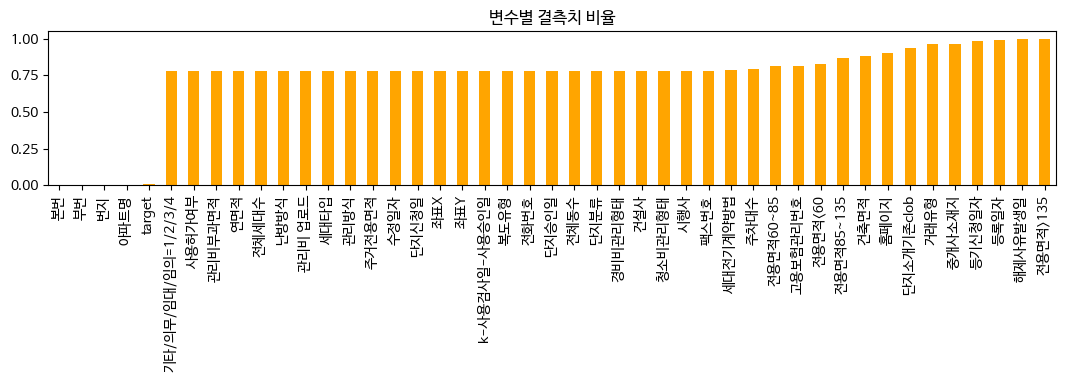

In [14]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = dt_concat.isnull().sum() / dt_concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

#### 피쳐 드랍

In [15]:
# display(dt_concat['거래유형'].value_counts())

In [18]:
# direct = dt_concat[(dt_concat['is_test']==0) & (dt_concat['거래유형']=='직거래')]['target']
# broker = dt_concat[(dt_concat['is_test']==0) & (dt_concat['거래유형']=='중개거래')]['target']

# t_stat, p_value = stats.ttest_ind(direct, broker)
# print("\nt-statistic:", t_stat)
# print("p-value:", p_value)


t-statistic: -28.3381116894659
p-value: 1.5942351178919688e-174


In [16]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(dt_concat.columns[dt_concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(dt_concat.columns[dt_concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '단지분류', '전화번호', '팩스번호', '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사', 'k-사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시', '구', '동', '계약년', '계약월']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', '전용면적>135', '홈페이지', '등록일자']


In [17]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(dt_concat.columns[dt_concat.isnull().sum() <= 1000000])
dt_concat_select = dt_concat[selected]

In [18]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
dt_concat_select['본번'] = dt_concat_select['본번'].astype('str')
dt_concat_select['부번'] = dt_concat_select['부번'].astype('str')

In [21]:
# 피쳐 드랍하기 이전중복 데이터 확인 후 제거  
pd.Series(dt_concat_select.duplicated()).value_counts()
dt_concat_select[dt_concat_select.duplicated(keep=False)].sort_values(by=list(dt_concat_select.columns)).head(10)
dt_concat_select = dt_concat_select.drop_duplicates(keep='first')
pd.Series(dt_concat_select.duplicated()).value_counts()

False    1124844
dtype: int64

In [22]:
dt_concat_select.shape

(1124844, 48)

In [26]:
# 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in dt_concat_select.columns:
    if pd.api.types.is_numeric_dtype(dt_concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '단지분류', '전화번호', '팩스번호', '세대타입', '관리방식', '복도유형', '난방방식', '건설사', '시행사', 'k-사용검사일-사용승인일', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동', '계약년', '계약월']


In [27]:
print(len(continuous_columns), len(categorical_columns))

18 30


In [28]:
# 드랍할 범주형 피쳐 정의
except_catcol = ['전화번호', '팩스번호', 'k-사용검사일-사용승인일', '수정일자', '고용보험관리번호', '청소비관리형태','단지승인일']

dt_concat_select = dt_concat_select.drop(columns=except_catcol)

In [29]:
# 드랍할 연속형 피쳐 확인
except_contcol = []

dt_concat_select = dt_concat_select.drop(columns=except_contcol)

#### 파생변수 생성

In [30]:
# 구 티어 
goo = list(dt_concat_select['구'].unique())

tier1 = ['강남구', '서초구', '용산구', '송파구', '성동구']
tier2 = ['마포구', '광진구', '동작구', '영등포구', '중구', '종로구', '강동구', '양천구', '서대문구']
# tier3 = ['동대문구', '강서구', '광악구', '은평구']


tier3 = [x for x in goo if x not in tier1 + tier2]

assert len(goo) == len(tier1) + len(tier2) + len(tier3)       # 알맞게 분리되었는지 체크합니다.

In [31]:
# 강남의 여부를 체크합니다.
goo_tier = []
for x in dt_concat_select['구'].tolist() :
  if x in tier1 :
    goo_tier.append(1)  
  elif x in tier2 :
    goo_tier.append(2)
  else :
    goo_tier.append(3)

# 파생변수를 하나 만릅니다.
dt_concat_select['구 티어'] = goo_tier

In [32]:
# 동 티어
dong = list(dt_concat_select['동'].unique())

# Define tiers
t1 = ['반포동', '개포동', '압구정동', '대치동', '잠원동', '잠실동', '일원동', '수서동', '평동', '홍파동', '삼성동', '청담동', '도곡동', '교북동', '성수동1가', '한남동', '용강동']
t2 = ['아현동', '신계동', '신천동', '역삼동', '보광동', '용산동5가', '북아현동', '만리동2가','용문동', '자곡동', '신원동', '이촌동', '성수동2가', '상수동', '서빙고동', '옥수동', '금호동4가', '고덕동', '금호동2가', '세곡동', '장지동', '현석동', '내곡동']
t3 = ['상왕십리동', '우면동', '염리동', '흑석동', '서초동', '한강로3가', '논현동', '여의도동', '방배동', '대흥동', '광장동', '상일동', '공덕동', '한강로1가', '방이동', '영등포동7가', '토정동', '중림동', '금호동1가', '원효로4가', '행당동', '신공덕동', '하왕십리동', '원효로1가', '동작동', '송파동', '만리동1가', '이태원동', '목동']


# Convert back to list if needed
t4 = [x for x in dong if x not in t1 + t2 + t3]

# # Check if all 'dong' are categorized
assert len(dong) == len(t1) + len(t2) + len(t3) + len(t4), "Mismatch in tier categorization"

In [33]:
dong_tier = []
for x in dt_concat_select['동'].tolist() :
    if x in t1 :
        dong_tier.append(1)
    elif x in t2 :
        dong_tier.append(2)
    else :
        dong_tier.append(3)
dt_concat_select['동 티어'] = dong_tier

In [34]:
# 건축년도 tier
dt_concat_select['건축년도'].describe(percentiles=[0.25, 0.5, 0.75, 1])


count    1.124844e+06
mean     1.998783e+03
std      9.352761e+00
min      1.961000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
100%     2.023000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [38]:
# 건축년도 tier
bldg_age = list(dt_concat_select['건축년도'].unique())

new = list(range(1961, 1992))
mid = list(range(1993, 2000))
old = list(range(2001, 2005))
vold = list(range(2006, 2023))

In [39]:
bldg_tier = []
for x in dt_concat_select['건축년도'].tolist() :
    if x in new :
        bldg_tier.append(1)
    elif x in mid :
        bldg_tier.append(2)
    elif x in old :
        bldg_tier.append(3)
    else :
        bldg_tier.append(4)
dt_concat_select['건축년도 티어'] = bldg_tier

In [40]:
dt_concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '단지분류',
       '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사', '연면적',
       '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '경비비관리형태',
       '세대전기계약방법', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시', '구', '동', '계약년', '계약월',
       '구 티어', '동 티어', '건축년도 티어'],
      dtype='object')

#### 상관관계 확인
- 전용면적, 관리비부과면적, 주거전용면적, 연면적, 주차대수와 높은 상관관계를 보임

- 건축년도와 전용면적은 반비례 관계를 보임

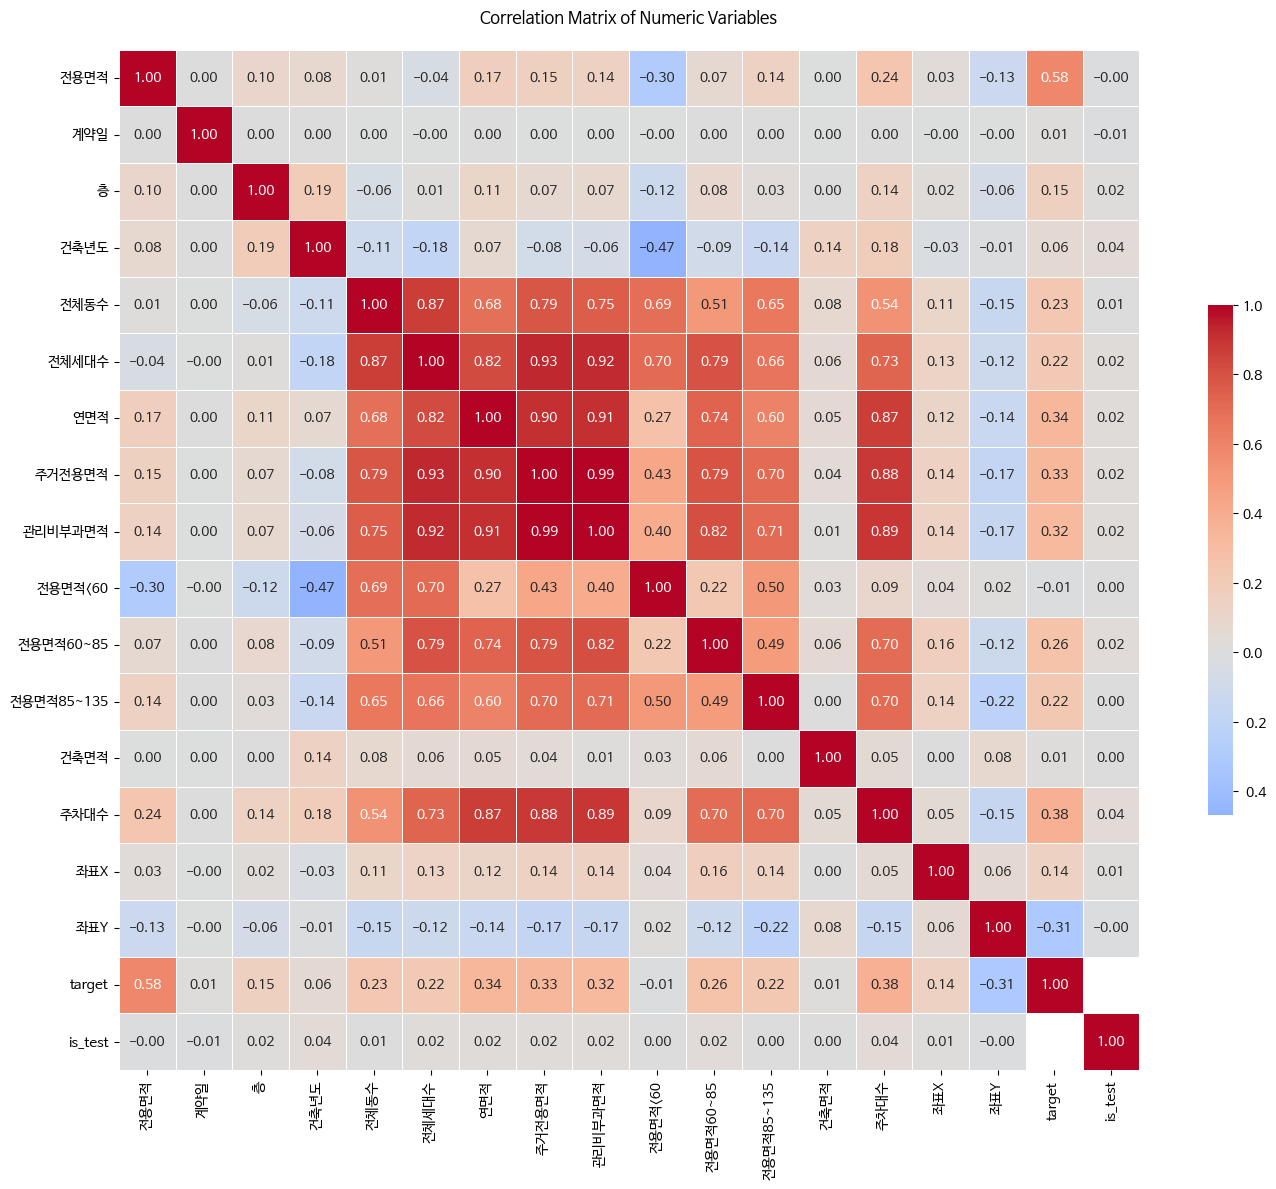

In [41]:
# 연속형 변수들의 상관관계 Heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(dt_concat_select[continuous_columns].corr(), 
            annot=True,              # 상관계수 표시
            cmap='coolwarm',         # 색
            center=0,                # 상관계수 표시 중심값 0
            fmt='.2f',              # 소수점 2자리 표시
            square=True,            # 정사각형 형태
            linewidths=0.5,         # 그리드 선 두께
            cbar_kws={"shrink": .5} # 색상 바 크기 조절
           )
plt.title('Correlation Matrix of Numeric Variables', pad=20)
plt.tight_layout()
plt.show()


### 변수 보간

#### train data 전처리

In [42]:
# train/test 데이터 분리
train_dt2 = dt_concat_select.query('is_test==0')
test_dt2 = dt_concat_select.query('is_test==1')

In [43]:
# 건축면적과 관리비부과면적 제거
# train_dt2 = train_dt2.drop(columns=['건축면적', '관리비부과면적', '좌표X', '좌표Y'])

In [44]:
# 위에서 피쳐 드랍을 했으니 다시 범주형, 연속형 변수 분리
continuous_columns = []
categorical_columns = []

for column in train_dt2.columns:
    if pd.api.types.is_numeric_dtype(train_dt2[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '구 티어', '동 티어', '건축년도 티어']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '단지분류', '세대타입', '관리방식', '복도유형', '난방방식', '건설사', '시행사', '경비비관리형태', '세대전기계약방법', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동', '계약년', '계약월']


In [45]:
train_dt2[categorical_columns].isnull().sum()

번지                        223
본번                          0
부번                          0
아파트명                     2114
도로명                         0
단지분류                   868374
세대타입                   867247
관리방식                   867247
복도유형                   867571
난방방식                   867247
건설사                    868738
시행사                    868934
경비비관리형태                868663
세대전기계약방법               876398
기타/의무/임대/임의=1/2/3/4    867247
사용허가여부                 867247
관리비 업로드                867247
단지신청일                  867309
시                           0
구                           0
동                           0
계약년                         0
계약월                         0
dtype: int64

In [46]:
train_dt2[continuous_columns].isnull().sum()



전용면적               0
계약일                0
층                  0
건축년도               0
전체동수          868312
전체세대수         867247
연면적           867247
주거전용면적        867292
관리비부과면적       867247
전용면적<60       920941
전용면적60~85     910135
전용면적85~135    966479
건축면적          984494
주차대수          885278
좌표X           867354
좌표Y           867354
target             0
is_test            0
구 티어               0
동 티어               0
건축년도 티어            0
dtype: int64

#### 수치형 변수 보간

In [117]:
# train_dt2.drop(columns=[''], inplace=True)
train_dt2 = train_dt2.dropna(subset=['아파트명', '번지'])

In [48]:
# 전체세대수와 전체동수 (기준: 아파트명, 동)
def regression_imputation(df = train_dt2):
    # 결측치가 없는 데이터로 모델 학습
    df_train = df.dropna(subset=['전체동수'])
    
    # 범주형 변수 인코딩
    df_encoded = df.copy()
    df_encoded['아파트명_encoded'] = LabelEncoder().fit_transform(df['아파트명'])
    df_encoded['동_encoded'] = LabelEncoder().fit_transform(df['동'])
    
    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = df_encoded.loc[df_train.index, ['아파트명_encoded', '동_encoded']]
    y_train = df_train['전체동수']
    model.fit(X_train, y_train)
    
    # 결측치 예측
    mask = df['전체동수'].isna()
    X_missing = df_encoded.loc[mask, ['아파트명_encoded', '동_encoded']]
    df.loc[mask, '전체동수'] = model.predict(X_missing)
    
    return df

# 적용
df_reg = regression_imputation(df = train_dt2)

In [49]:
# 전체세대수와 전체동수 (기준: 아파트명, 동)
def regression_imputation(df = train_dt2):
    # 결측치가 없는 데이터로 모델 학습
    df_train = df.dropna(subset=['전체세대수'])
    
    # 범주형 변수 인코딩
    df_encoded = df.copy()
    df_encoded['아파트명_encoded'] = LabelEncoder().fit_transform(df['아파트명'])
    df_encoded['동_encoded'] = LabelEncoder().fit_transform(df['동'])
    
    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = df_encoded.loc[df_train.index, ['아파트명_encoded', '동_encoded']]
    y_train = df_train['전체세대수']
    model.fit(X_train, y_train)
    
    # 결측치 예측
    mask = df['전체세대수'].isna()
    X_missing = df_encoded.loc[mask, ['아파트명_encoded', '동_encoded']]
    df.loc[mask, '전체세대수'] = model.predict(X_missing)
    
    return df

# 적용
df_reg = regression_imputation(df = train_dt2)

In [50]:
# 주거전용면적과 연면적 (기준: 아파트명, 건축년도, 전용면적)
def regression_imputation(df = train_dt2):
    # 결측치가 없는 데이터로 모델 학습
    df_train = df.dropna(subset=['연면적'])
    
    # 범주형 변수 인코딩
    df_encoded = df.copy()
    df_encoded['아파트명_encoded'] = LabelEncoder().fit_transform(df['아파트명'])
    df_encoded['전용면적_encoded'] = LabelEncoder().fit_transform(df['전용면적'])
    df_encoded['건축년도_encoded'] = LabelEncoder().fit_transform(df['건축년도'])
    
    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = df_encoded.loc[df_train.index, ['아파트명_encoded', '건축년도_encoded', '전용면적_encoded']]
    y_train = df_train['연면적']
    model.fit(X_train, y_train)
    
    # 결측치 예측
    mask = df['연면적'].isna()
    X_missing = df_encoded.loc[mask, ['아파트명_encoded', '건축년도_encoded', '전용면적_encoded']]
    df.loc[mask, '연면적'] = model.predict(X_missing)
    
    return df

# 적용
df_reg = regression_imputation(df = train_dt2)

In [51]:
# 주거전용면적과 연면적 (기준: 아파트명, 건축년도, 전용면적)
def regression_imputation(df = train_dt2):
    # 결측치가 없는 데이터로 모델 학습
    df_train = df.dropna(subset=['주거전용면적'])
    
    # 범주형 변수 인코딩
    df_encoded = df.copy()
    df_encoded['아파트명_encoded'] = LabelEncoder().fit_transform(df['아파트명'])
    df_encoded['전용면적_encoded'] = LabelEncoder().fit_transform(df['전용면적'])
    df_encoded['건축년도_encoded'] = LabelEncoder().fit_transform(df['건축년도'])
    
    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = df_encoded.loc[df_train.index, ['아파트명_encoded', '건축년도_encoded', '전용면적_encoded']]
    y_train = df_train['주거전용면적']
    model.fit(X_train, y_train)
    
    # 결측치 예측
    mask = df['주거전용면적'].isna()
    X_missing = df_encoded.loc[mask, ['아파트명_encoded', '건축년도_encoded', '전용면적_encoded']]
    df.loc[mask, '주거전용면적'] = model.predict(X_missing)
    
    return df

# 적용
df_reg = regression_imputation(df = train_dt2)

In [52]:
# 주차대수 (기준: 전체세대수 전용면적)
def regression_imputation(df = train_dt2):
    # 결측치가 없는 데이터로 모델 학습
    df_train = df.dropna(subset=['주차대수'])
    
    # 범주형 변수 인코딩
    df_encoded = df.copy()
    df_encoded['전체세대수_encoded'] = LabelEncoder().fit_transform(df['전체세대수'])
    df_encoded['전용면적_encoded'] = LabelEncoder().fit_transform(df['전용면적'])
    
    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = df_encoded.loc[df_train.index, ['전체세대수_encoded', '전용면적_encoded']]
    y_train = df_train['주차대수']
    model.fit(X_train, y_train)
    
    # 결측치 예측
    mask = df['주차대수'].isna()
    X_missing = df_encoded.loc[mask, ['전체세대수_encoded', '전용면적_encoded']]
    df.loc[mask, '주차대수'] = model.predict(X_missing)
    
    return df

# 적용
df_reg = regression_imputation(df = train_dt2)

In [53]:
# 전용면적<60, 전용면적60~85, 전용면적85~135 (기준: 아파트명, 주거전용면적, 전용면적)
def regression_imputation(df = train_dt2):
    # 결측치가 없는 데이터로 모델 학습
    df_train = df.dropna(subset=['전용면적<60'])
    
    # 범주형 변수 인코딩
    df_encoded = df.copy()
    df_encoded['아파트명_encoded'] = LabelEncoder().fit_transform(df['아파트명'])
    df_encoded['주거전용면적_encoded'] = LabelEncoder().fit_transform(df['주거전용면적'])
    df_encoded['전용면적_encoded'] = LabelEncoder().fit_transform(df['전용면적'])
    
    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = df_encoded.loc[df_train.index, ['아파트명_encoded', '주거전용면적_encoded', '전용면적_encoded']]
    y_train = df_train['전용면적<60']
    model.fit(X_train, y_train)
    

    
    # 결측치 예측
    mask = df['전용면적<60'].isna()
    X_missing = df_encoded.loc[mask, ['아파트명_encoded', '주거전용면적_encoded', '전용면적_encoded']]
    df.loc[mask, '전용면적<60'] = model.predict(X_missing)
    
    return df

# 적용
df_reg = regression_imputation(df = train_dt2)

In [54]:
# 전용면적<60, 전용면적60~85, 전용면적85~135 (기준: 아파트명, 주거전용면적, 전용면적)
def regression_imputation(df = train_dt2):
    # 결측치가 없는 데이터로 모델 학습
    df_train = df.dropna(subset=['전용면적60~85'])
    
    # 범주형 변수 인코딩
    df_encoded = df.copy()
    df_encoded['아파트명_encoded'] = LabelEncoder().fit_transform(df['아파트명'])
    df_encoded['주거전용면적_encoded'] = LabelEncoder().fit_transform(df['주거전용면적'])
    df_encoded['전용면적_encoded'] = LabelEncoder().fit_transform(df['전용면적'])
    
    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = df_encoded.loc[df_train.index, ['아파트명_encoded', '주거전용면적_encoded', '전용면적_encoded']]
    y_train = df_train['전용면적60~85']
    model.fit(X_train, y_train)
    

    
    # 결측치 예측
    mask = df['전용면적60~85'].isna()
    X_missing = df_encoded.loc[mask, ['아파트명_encoded', '주거전용면적_encoded', '전용면적_encoded']]
    df.loc[mask, '전용면적60~85'] = model.predict(X_missing)
    
    return df

# 적용
df_reg = regression_imputation(df = train_dt2)

In [55]:
# 전용면적<60, 전용면적60~85, 전용면적85~135 (기준: 아파트명, 주거전용면적, 전용면적)
def regression_imputation(df = train_dt2):
    # 결측치가 없는 데이터로 모델 학습
    df_train = df.dropna(subset=['전용면적85~135'])
    
    # 범주형 변수 인코딩
    df_encoded = df.copy()
    df_encoded['아파트명_encoded'] = LabelEncoder().fit_transform(df['아파트명'])
    df_encoded['주거전용면적_encoded'] = LabelEncoder().fit_transform(df['주거전용면적'])
    df_encoded['전용면적_encoded'] = LabelEncoder().fit_transform(df['전용면적'])
    
    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = df_encoded.loc[df_train.index, ['아파트명_encoded', '주거전용면적_encoded', '전용면적_encoded']]
    y_train = df_train['전용면적85~135']
    model.fit(X_train, y_train)
    

    
    # 결측치 예측
    mask = df['전용면적85~135'].isna()
    X_missing = df_encoded.loc[mask, ['아파트명_encoded', '주거전용면적_encoded', '전용면적_encoded']]
    df.loc[mask, '전용면적85~135'] = model.predict(X_missing)
    
    return df

# 적용
df_reg = regression_imputation(df = train_dt2)

In [56]:
# Encoding 방법에 따라 피쳐 분리 정의
log_col = ['']
minmax_col = ['']
std_col = ['']
robust_col = ['']
bin_col = ['주차대수']

In [155]:
train_dt2['주차대수'].value_counts()
train_dt2['주차대수'].isnull().sum()

0

In [59]:
# Binning
train_dt2['주차대수'].describe(percentiles=[0.25, 0.5, 0.75, 1])
bins = [0, 80, 740, 1350, 12100]

# 구간마다 레이블을 정해줍니다.
labels = ["CarLess", "CarM", "CarH", "CarVH"]

# Binning을 수행합니다.
train_dt2['주차대수'] = pd.cut(train_dt2['주차대수'], bins=bins, labels=labels)

display(train_dt2)

TypeError: '<' not supported between instances of 'int' and 'str'

In [60]:
#  다시 범주형, 연속형 변수 분리
continuous_columns = []
categorical_columns = []

for column in train_dt2.columns:
    if pd.api.types.is_numeric_dtype(train_dt2[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

train_dt2[continuous_columns].isnull().sum()
train_dt2[categorical_columns].isnull().sum()

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '건축면적', '좌표X', '좌표Y', 'target', 'is_test', '구 티어', '동 티어', '건축년도 티어']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '단지분류', '세대타입', '관리방식', '복도유형', '난방방식', '건설사', '시행사', '경비비관리형태', '세대전기계약방법', '주차대수', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동', '계약년', '계약월']


번지                          0
본번                          0
부번                          0
아파트명                        0
도로명                         0
단지분류                   866185
세대타입                   865058
관리방식                   865058
복도유형                   865382
난방방식                   865058
건설사                    866549
시행사                    866745
경비비관리형태                866474
세대전기계약방법               874209
주차대수                        0
기타/의무/임대/임의=1/2/3/4    865058
사용허가여부                 865058
관리비 업로드                865058
단지신청일                  865120
시                           0
구                           0
동                           0
계약년                         0
계약월                         0
dtype: int64

#### 범주형 변수 보간

In [64]:
# 위에서 피쳐 드랍을 했으니 다시 범주형, 연속형 변수 분리
continuous_columns = []
categorical_columns = []

for column in train_dt2.columns:
    if pd.api.types.is_numeric_dtype(train_dt2[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '전용면적<60', '전용면적60~85', '전용면적85~135', 'target', 'is_test', '구 티어', '동 티어', '건축년도 티어']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '단지분류', '세대타입', '관리방식', '복도유형', '난방방식', '건설사', '시행사', '경비비관리형태', '세대전기계약방법', '주차대수', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '시', '구', '동', '계약년', '계약월']


In [62]:
train_dt2.drop(columns=['관리비부과면적', '좌표X', '좌표Y', '건축면적', '단지신청일'], inplace=True)



In [80]:
train_dt2[continuous_columns].isnull().sum()
train_dt2[categorical_columns].isnull().sum()

번지                     0
본번                     0
부번                     0
아파트명                   0
도로명                    0
단지분류                   0
세대타입                   0
관리방식                   0
복도유형                   0
난방방식                   0
건설사                    0
시행사                    0
경비비관리형태                0
세대전기계약방법               0
주차대수                   0
기타/의무/임대/임의=1/2/3/4    0
사용허가여부                 0
관리비 업로드                0
시                      0
구                      0
동                      0
계약년                    0
계약월                    0
dtype: int64

In [66]:
# # 관리방식, 경비비관리형태, 세대전기계약방법, 기타/의무/임대/임의, 사용허가여부, 관리비 업로드
def mode_imputation(categorical_cols, df=train_dt2):
    df_imputed = df.copy()
    
    for col in categorical_cols:
        # 최빈값 계산 (여러 개인 경우 첫 번째 값 사용)
        mode_val = df[col].mode()[0]
        df_imputed[col] = df[col].fillna(mode_val)
        
        print(f"{col} 컬럼의 최빈값: {mode_val}")
        
    return df_imputed

# 적용
categorical_cols = ['세대타입', '관리방식', '경비비관리형태', '세대전기계약방법', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드']
train_dt2 = mode_imputation(df=train_dt2, categorical_cols=categorical_cols)

세대타입 컬럼의 최빈값: 분양
관리방식 컬럼의 최빈값: 위탁관리
경비비관리형태 컬럼의 최빈값: 위탁
세대전기계약방법 컬럼의 최빈값: 종합계약
기타/의무/임대/임의=1/2/3/4 컬럼의 최빈값: 의무
사용허가여부 컬럼의 최빈값: Y
관리비 업로드 컬럼의 최빈값: N


In [68]:
    # 조건부 최빈값 
    # 단지분류(전체동수, 주차대수) 복도유형(아파트명, 건축년도) 난방방식(아파트명, 건축년도, 전용면적), 건설사/시행사 : 세대수, 연면적, 단지분류
def conditional_mode_imputation_fast(target_col, condition_cols, df=train_dt2):
    df_imputed = df.copy()
    missing_mask = df[target_col].isna()
    
    if not missing_mask.any():
        print(f"{target_col}의 결측치가 없습니다.")
        return df_imputed
    
    print(f"처리할 결측치 수: {missing_mask.sum()}")
    
    # 1. 조건 컬럼들을 결합하여 하나의 키로 만듦
    df_imputed['temp_key'] = df_imputed[condition_cols].astype(str).agg('_'.join, axis=1)
    
    # 2. 각 조건 조합별 최빈값을 한 번에 계산
    mode_dict = df_imputed[~missing_mask].groupby('temp_key')[target_col].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    ).to_dict()
    
    # 3. 전체 최빈값 계산
    overall_mode = df_imputed[target_col].mode()[0]
    
    # 4. 결측치가 있는 행들의 키에 대해 한 번에 값을 채움
    missing_keys = df_imputed.loc[missing_mask, 'temp_key']
    df_imputed.loc[missing_mask, target_col] = missing_keys.map(
        lambda x: mode_dict.get(x, overall_mode)
    )
    
    # 5. 임시 키 컬럼 제거
    df_imputed.drop('temp_key', axis=1, inplace=True)
    
    print(f"처리 완료: {missing_mask.sum()}개 결측치 대체")
    return df_imputed

# 실행
print("처리 시작...")
for col in tqdm(['단지분류'], desc="전체 진행률"):
    print(f"\n{col} 처리 중...")
    train_dt2 = conditional_mode_imputation_fast(
        target_col=col,
        condition_cols=['전체세대수', '주차대수'],
        df=train_dt2
    )
    print(f"\n{col} 결측치 수: {train_dt2[col].isna().sum()}")

처리 시작...


전체 진행률:   0%|          | 0/1 [00:00<?, ?it/s]


단지분류 처리 중...
처리할 결측치 수: 866185


전체 진행률: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]

처리 완료: 866185개 결측치 대체

단지분류 결측치 수: 0


In [74]:
# 조건부 최빈값 
# 단지분류(전체동수, 주차대수) 복도유형(아파트명, 건축년도) 난방방식(아파트명, 건축년도, 전용면적), 건설사/시행사 : 세대수, 연면적, 단지분류
def conditional_mode_imputation_fast(target_col, condition_cols, df=train_dt2):
    df_imputed = df.copy()
    missing_mask = df[target_col].isna()
    
    if not missing_mask.any():
        print(f"{target_col}의 결측치가 없습니다.")
        return df_imputed
    
    print(f"처리할 결측치 수: {missing_mask.sum()}")
    
    # 1. 조건 컬럼들을 결합하여 하나의 키로 만듦
    df_imputed['temp_key'] = df_imputed[condition_cols].astype(str).agg('_'.join, axis=1)
    
    # 2. 각 조건 조합별 최빈값을 한 번에 계산
    mode_dict = df_imputed[~missing_mask].groupby('temp_key')[target_col].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    ).to_dict()
    
    # 3. 전체 최빈값 계산
    overall_mode = df_imputed[target_col].mode()[0]
    
    # 4. 결측치가 있는 행들의 키에 대해 한 번에 값을 채움
    missing_keys = df_imputed.loc[missing_mask, 'temp_key']
    df_imputed.loc[missing_mask, target_col] = missing_keys.map(
        lambda x: mode_dict.get(x, overall_mode)
    )
    
    # 5. 임시 키 컬럼 제거
    df_imputed.drop('temp_key', axis=1, inplace=True)
    
    print(f"처리 완료: {missing_mask.sum()}개 결측치 대체")
    return df_imputed

# 실행
print("처리 시작...")
for col in tqdm(['복도유형'], desc="전체 진행률"):
    print(f"\n{col} 처리 중...")
    train_dt2 = conditional_mode_imputation_fast(
        target_col=col,
        condition_cols=['아파트명', '건축년도'],
        df=train_dt2
    )
    print(f"\n{col} 결측치 수: {train_dt2[col].isna().sum()}")

처리 시작...


전체 진행률:   0%|          | 0/1 [00:00<?, ?it/s]


복도유형 처리 중...
처리할 결측치 수: 865382


전체 진행률: 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]

처리 완료: 865382개 결측치 대체

복도유형 결측치 수: 0


In [76]:
# 조건부 최빈값 
# 단지분류(전체동수, 주차대수) 복도유형(아파트명, 건축년도) 난방방식(아파트명, 건축년도, 전용면적), 건설사/시행사 : 세대수, 연면적, 단지분류
def conditional_mode_imputation_fast(target_col, condition_cols, df=train_dt2):
    df_imputed = df.copy()
    missing_mask = df[target_col].isna()
    
    if not missing_mask.any():
        print(f"{target_col}의 결측치가 없습니다.")
        return df_imputed
    
    print(f"처리할 결측치 수: {missing_mask.sum()}")
    
    # 1. 조건 컬럼들을 결합하여 하나의 키로 만듦
    df_imputed['temp_key'] = df_imputed[condition_cols].astype(str).agg('_'.join, axis=1)
    
    # 2. 각 조건 조합별 최빈값을 한 번에 계산
    mode_dict = df_imputed[~missing_mask].groupby('temp_key')[target_col].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    ).to_dict()
    
    # 3. 전체 최빈값 계산
    overall_mode = df_imputed[target_col].mode()[0]
    
    # 4. 결측치가 있는 행들의 키에 대해 한 번에 값을 채움
    missing_keys = df_imputed.loc[missing_mask, 'temp_key']
    df_imputed.loc[missing_mask, target_col] = missing_keys.map(
        lambda x: mode_dict.get(x, overall_mode)
    )
    
    # 5. 임시 키 컬럼 제거
    df_imputed.drop('temp_key', axis=1, inplace=True)
    
    print(f"처리 완료: {missing_mask.sum()}개 결측치 대체")
    return df_imputed

# 실행
print("처리 시작...")
for col in tqdm(['난방방식'], desc="전체 진행률"):
    print(f"\n{col} 처리 중...")
    train_dt2 = conditional_mode_imputation_fast(
        target_col=col,
        condition_cols=['아파트명', '건축년도', '전용면적'],
        df=train_dt2
    )
    print(f"\n{col} 결측치 수: {train_dt2[col].isna().sum()}")

처리 시작...


전체 진행률:   0%|          | 0/1 [00:00<?, ?it/s]


난방방식 처리 중...
난방방식의 결측치가 없습니다.


전체 진행률: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


난방방식 결측치 수: 0


In [77]:
# 조건부 최빈값 
# 단지분류(전체동수, 주차대수) 복도유형(아파트명, 건축년도) 난방방식(아파트명, 건축년도, 전용면적), 건설사/시행사 : 세대수, 연면적, 단지분류
def conditional_mode_imputation_fast(target_col, condition_cols, df=train_dt2):
    df_imputed = df.copy()
    missing_mask = df[target_col].isna()
    
    if not missing_mask.any():
        print(f"{target_col}의 결측치가 없습니다.")
        return df_imputed
    
    print(f"처리할 결측치 수: {missing_mask.sum()}")
    
    # 1. 조건 컬럼들을 결합하여 하나의 키로 만듦
    df_imputed['temp_key'] = df_imputed[condition_cols].astype(str).agg('_'.join, axis=1)
    
    # 2. 각 조건 조합별 최빈값을 한 번에 계산
    mode_dict = df_imputed[~missing_mask].groupby('temp_key')[target_col].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    ).to_dict()
    
    # 3. 전체 최빈값 계산
    overall_mode = df_imputed[target_col].mode()[0]
    
    # 4. 결측치가 있는 행들의 키에 대해 한 번에 값을 채움
    missing_keys = df_imputed.loc[missing_mask, 'temp_key']
    df_imputed.loc[missing_mask, target_col] = missing_keys.map(
        lambda x: mode_dict.get(x, overall_mode)
    )
    
    # 5. 임시 키 컬럼 제거
    df_imputed.drop('temp_key', axis=1, inplace=True)
    
    print(f"처리 완료: {missing_mask.sum()}개 결측치 대체")
    return df_imputed

# 실행
print("처리 시작...")
for col in tqdm(['건설사'], desc="전체 진행률"):
    print(f"\n{col} 처리 중...")
    train_dt2 = conditional_mode_imputation_fast(
        target_col=col,
        condition_cols=['전체세대수', '연면적', '단지분류'],
        df=train_dt2
    )
    print(f"\n{col} 결측치 수: {train_dt2[col].isna().sum()}")

처리 시작...


전체 진행률:   0%|          | 0/1 [00:00<?, ?it/s]


건설사 처리 중...
처리할 결측치 수: 866549


전체 진행률: 100%|██████████| 1/1 [00:06<00:00,  6.68s/it]

처리 완료: 866549개 결측치 대체

건설사 결측치 수: 0


In [78]:
# 조건부 최빈값 
# 단지분류(전체동수, 주차대수) 복도유형(아파트명, 건축년도) 난방방식(아파트명, 건축년도, 전용면적), 건설사/시행사 : 세대수, 연면적, 단지분류
def conditional_mode_imputation_fast(target_col, condition_cols, df=train_dt2):
    df_imputed = df.copy()
    missing_mask = df[target_col].isna()
    
    if not missing_mask.any():
        print(f"{target_col}의 결측치가 없습니다.")
        return df_imputed
    
    print(f"처리할 결측치 수: {missing_mask.sum()}")
    
    # 1. 조건 컬럼들을 결합하여 하나의 키로 만듦
    df_imputed['temp_key'] = df_imputed[condition_cols].astype(str).agg('_'.join, axis=1)
    
    # 2. 각 조건 조합별 최빈값을 한 번에 계산
    mode_dict = df_imputed[~missing_mask].groupby('temp_key')[target_col].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    ).to_dict()
    
    # 3. 전체 최빈값 계산
    overall_mode = df_imputed[target_col].mode()[0]
    
    # 4. 결측치가 있는 행들의 키에 대해 한 번에 값을 채움
    missing_keys = df_imputed.loc[missing_mask, 'temp_key']
    df_imputed.loc[missing_mask, target_col] = missing_keys.map(
        lambda x: mode_dict.get(x, overall_mode)
    )
    
    # 5. 임시 키 컬럼 제거
    df_imputed.drop('temp_key', axis=1, inplace=True)
    
    print(f"처리 완료: {missing_mask.sum()}개 결측치 대체")
    return df_imputed

# 실행
print("처리 시작...")
for col in tqdm(['시행사'], desc="전체 진행률"):
    print(f"\n{col} 처리 중...")
    train_dt2 = conditional_mode_imputation_fast(
        target_col=col,
        condition_cols=['전체세대수', '연면적', '단지분류'],
        df=train_dt2
    )
    print(f"\n{col} 결측치 수: {train_dt2[col].isna().sum()}")

처리 시작...


전체 진행률:   0%|          | 0/1 [00:00<?, ?it/s]


시행사 처리 중...
처리할 결측치 수: 866745


전체 진행률: 100%|██████████| 1/1 [00:06<00:00,  6.66s/it]

처리 완료: 866745개 결측치 대체

시행사 결측치 수: 0


In [79]:
train_dt2.isnull().sum()

번지                     0
본번                     0
부번                     0
아파트명                   0
전용면적                   0
계약일                    0
층                      0
건축년도                   0
도로명                    0
단지분류                   0
세대타입                   0
관리방식                   0
복도유형                   0
난방방식                   0
전체동수                   0
전체세대수                  0
건설사                    0
시행사                    0
연면적                    0
주거전용면적                 0
전용면적<60                0
전용면적60~85              0
전용면적85~135             0
경비비관리형태                0
세대전기계약방법               0
주차대수                   0
기타/의무/임대/임의=1/2/3/4    0
사용허가여부                 0
관리비 업로드                0
target                 0
is_test                0
시                      0
구                      0
동                      0
계약년                    0
계약월                    0
구 티어                   0
동 티어                   0
건축년도 티어                0
dtype: int64

In [106]:
train_dt2[continuous_columns].describe()

,전용면적,계약일,층,건축년도,전체동수,전체세대수,연면적,주거전용면적,전용면적<60,전용면적60~85,전용면적85~135,target,is_test,구 티어,동 티어,건축년도 티어
count,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1113399.0,1.113399e+06,1.113399e+06,1.113399e+06
mean,7.722581e+01,1.580761e+01,8.881450e+00,1.998747e+03,8.606882e+00,7.132555e+02,9.795114e+04,5.763709e+04,3.936142e+02,3.233408e+02,1.566720e+02,5.792354e+04,0.0,2.254209e+00,2.772659e+00,2.666140e+00
std,2.933244e+01,8.721005e+00,5.980544e+00,9.328752e+00,1.150960e+01,8.283381e+02,1.295621e+05,6.886118e+04,5.295789e+02,4.409275e+02,1.791828e+02,4.622250e+04,0.0,8.044587e-01,5.937152e-01,1.168414e+00
min,1.002000e+01,1.000000e+00,1.000000e+00,1.961000e+03,1.000000e+00,5.900000e+01,0.000000e+00,2.338000e+03,1.000000e+00,1.000000e+00,1.000000e+00,3.500000e+02,0.0,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.967000e+01,8.000000e+00,4.000000e+00,1.992000e+03,3.000000e+00,2.670300e+02,3.556746e+04,2.159890e+04,1.243700e+02,1.205500e+02,4.805000e+01,3.050000e+04,0.0,2.000000e+00,3.000000e+00,2.000000e+00
50%,8.198530e+01,1.600000e+01,8.000000e+00,2.000000e+03,5.390000e+00,4.490000e+02,6.067661e+04,3.645726e+04,2.200000e+02,2.028800e+02,9.452000e+01,4.475000e+04,0.0,2.000000e+00,3.000000e+00,3.000000e+00
75%,8.496000e+01,2.300000e+01,1.200000e+01,2.005000e+03,1.000000e+01,8.000000e+02,1.107011e+05,6.728900e+04,4.493100e+02,3.622800e+02,1.825200e+02,6.950000e+04,0.0,3.000000e+00,3.000000e+00,4.000000e+00
max,4.243200e+02,3.100000e+01,6.900000e+01,2.023000e+03,1.240000e+02,9.510000e+03,9.591851e+06,7.347810e+05,4.975000e+03,5.132000e+03,1.500000e+03,1.450000e+06,0.0,3.000000e+00,3.000000e+00,4.000000e+00


#### 함수변환

In [109]:
# Log Transformation
Log_col = ['주거전용면적', '연면적']
for col in Log_col:
    train_dt2[f'{col}_log'] = np.log1p(train_dt2[col])

print("\n로그 변환된 컬럼의 통계량:")
print(train_dt2[[f'{col}_log' for col in Log_col]].describe())




로그 변환된 컬럼의 통계량:
         주거전용면적_log       연면적_log
count  1.113399e+06  1.113399e+06
mean   1.057099e+01  1.107180e+01
std    8.450666e-01  9.317903e-01
min    7.757479e+00  0.000000e+00
25%    9.980444e+00  1.047921e+01
50%    1.050392e+01  1.101333e+01
75%    1.111677e+01  1.161460e+01
max    1.350733e+01  1.607642e+01


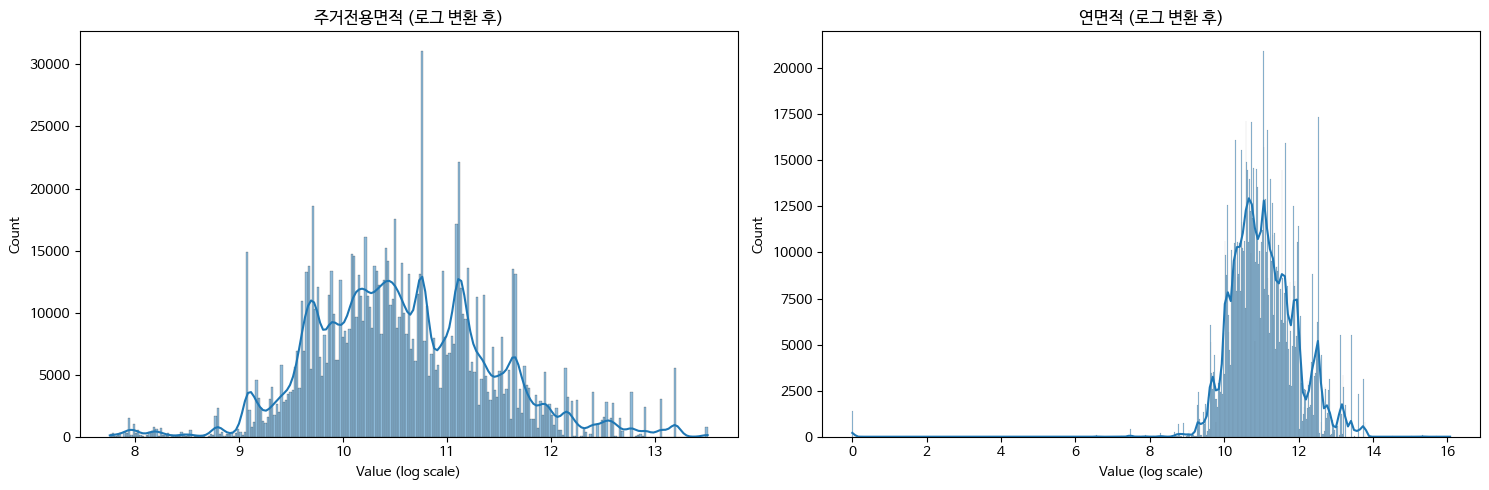

In [113]:
# 1. 히스토그램과 커널밀도 플롯을 함께 보여주는 방법
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(15, 5))

# 로그 변환된 컬럼들에 대해 subplot 생성
for idx, col in enumerate(Log_col, 1):
    plt.subplot(1, 2, idx)
    
    # histplot으로 히스토그램과 커널밀도를 함께 표시
    sns.histplot(data=train_dt2, x=f'{col}_log', kde=True)
    
    plt.title(f'{col} (로그 변환 후)')
    plt.xlabel('Value (log scale)')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [107]:
# from sklearn.preprocessing import RobustScaler
# # Robust Scaling
# Robust_col = ['주거전용면적', '연면적']

# for col in Robust_col:
#     scaler = RobustScaler()
#     train_dt2[f'{col}_robust'] = scaler.fit_transform(train_dt2[col])

# print(train_dt2[[f'{col}_robust' for col in Robust_col]].describe())

# # # scatter plot 확인
# # sns.scatterplot(data=train_dt2, x=, y='', color='', marker='', s=80)
# # plt.show()

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [ ]:
# # Standard Scaling
# Std_col = ['', '']

# for col in Std_col:
#     scaler = StandardScaler()
#     preprocessed_data[f'Std_{col}'] = scaler.fit_transform(preprocessed_data[col])
# # 
# display(preprocessed_data.describe())

# # scatter plot 확인
# sns.scatterplot(data=preprocessed_data, x='', y='', color='', marker='', s=80)
# plt.show()


#### Encoding

In [85]:
train_dt2[continuous_columns].head()

,전용면적,계약일,층,건축년도,전체동수,전체세대수,연면적,주거전용면적,전용면적<60,전용면적60~85,전용면적85~135,target,is_test,구 티어,동 티어,건축년도 티어
0,79.97,8,3,1987,8.0,270.0,22637.0,20204.0,20.0,250.0,52.00,124000.0,0,1,1,1
1,79.97,22,4,1987,8.0,270.0,22637.0,20204.0,20.0,250.0,52.00,123500.0,0,1,1,1
2,54.98,28,5,1987,8.0,270.0,22637.0,20204.0,20.0,250.0,64.48,91500.0,0,1,1,1
3,79.97,3,4,1987,8.0,270.0,22637.0,20204.0,20.0,250.0,52.00,130000.0,0,1,1,1
4,79.97,8,2,1987,8.0,270.0,22637.0,20204.0,20.0,250.0,52.00,117000.0,0,1,1,1


In [86]:
train_dt2[categorical_columns].head()

,번지,본번,부번,아파트명,도로명,단지분류,세대타입,관리방식,복도유형,난방방식,...,세대전기계약방법,주차대수,기타/의무/임대/임의=1/2/3/4,사용허가여부,관리비 업로드,시,구,동,계약년,계약월
0,658-1,658.0,1.0,개포6차우성,언주로 3,아파트,분양,자치관리,계단식,개별난방,...,단일계약,CarM,임의,Y,N,서울특별시,강남구,개포동,2017,12
1,658-1,658.0,1.0,개포6차우성,언주로 3,아파트,분양,자치관리,계단식,개별난방,...,단일계약,CarM,임의,Y,N,서울특별시,강남구,개포동,2017,12
2,658-1,658.0,1.0,개포6차우성,언주로 3,아파트,분양,자치관리,계단식,개별난방,...,단일계약,CarM,임의,Y,N,서울특별시,강남구,개포동,2017,12
3,658-1,658.0,1.0,개포6차우성,언주로 3,아파트,분양,자치관리,계단식,개별난방,...,단일계약,CarM,임의,Y,N,서울특별시,강남구,개포동,2018,01
4,658-1,658.0,1.0,개포6차우성,언주로 3,아파트,분양,자치관리,계단식,개별난방,...,단일계약,CarM,임의,Y,N,서울특별시,강남구,개포동,2018,01


In [84]:
train_dt2[continuous_columns].describe()


,전용면적,계약일,층,건축년도,전체동수,전체세대수,연면적,주거전용면적,전용면적<60,전용면적60~85,전용면적85~135,target,is_test,구 티어,동 티어,건축년도 티어
count,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1.113399e+06,1113399.0,1.113399e+06,1.113399e+06,1.113399e+06
mean,7.722581e+01,1.580761e+01,8.881450e+00,1.998747e+03,8.606882e+00,7.132555e+02,9.795114e+04,5.763709e+04,3.936142e+02,3.233408e+02,1.566720e+02,5.792354e+04,0.0,2.254209e+00,2.772659e+00,2.666140e+00
std,2.933244e+01,8.721005e+00,5.980544e+00,9.328752e+00,1.150960e+01,8.283381e+02,1.295621e+05,6.886118e+04,5.295789e+02,4.409275e+02,1.791828e+02,4.622250e+04,0.0,8.044587e-01,5.937152e-01,1.168414e+00
min,1.002000e+01,1.000000e+00,1.000000e+00,1.961000e+03,1.000000e+00,5.900000e+01,0.000000e+00,2.338000e+03,1.000000e+00,1.000000e+00,1.000000e+00,3.500000e+02,0.0,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.967000e+01,8.000000e+00,4.000000e+00,1.992000e+03,3.000000e+00,2.670300e+02,3.556746e+04,2.159890e+04,1.243700e+02,1.205500e+02,4.805000e+01,3.050000e+04,0.0,2.000000e+00,3.000000e+00,2.000000e+00
50%,8.198530e+01,1.600000e+01,8.000000e+00,2.000000e+03,5.390000e+00,4.490000e+02,6.067661e+04,3.645726e+04,2.200000e+02,2.028800e+02,9.452000e+01,4.475000e+04,0.0,2.000000e+00,3.000000e+00,3.000000e+00
75%,8.496000e+01,2.300000e+01,1.200000e+01,2.005000e+03,1.000000e+01,8.000000e+02,1.107011e+05,6.728900e+04,4.493100e+02,3.622800e+02,1.825200e+02,6.950000e+04,0.0,3.000000e+00,3.000000e+00,4.000000e+00
max,4.243200e+02,3.100000e+01,6.900000e+01,2.023000e+03,1.240000e+02,9.510000e+03,9.591851e+06,7.347810e+05,4.975000e+03,5.132000e+03,1.500000e+03,1.450000e+06,0.0,3.000000e+00,3.000000e+00,4.000000e+00


In [87]:
train_dt2[categorical_columns].isnull().sum()

번지                     0
본번                     0
부번                     0
아파트명                   0
도로명                    0
단지분류                   0
세대타입                   0
관리방식                   0
복도유형                   0
난방방식                   0
건설사                    0
시행사                    0
경비비관리형태                0
세대전기계약방법               0
주차대수                   0
기타/의무/임대/임의=1/2/3/4    0
사용허가여부                 0
관리비 업로드                0
시                      0
구                      0
동                      0
계약년                    0
계약월                    0
dtype: int64

In [88]:
# Encoding 방법에 따라 피쳐 분리 정의
ohe_col = ['사용허가여부', '시']
le_col = ['단지분류', '세대타입', '복도유형', '난방방식', '경비비관리형태', '세대전기계약방식', '관리비 업로드', '기타/의무/임대/임의=1/2/3/4', '주차대수']
freq_col = ['아파트명','건설사', '구', '동', '계약년', '계약월']
te_col = []

In [93]:
from sklearn.preprocessing import OneHotEncoder
OHE_col = ['사용허가여부', '시']
for col in OHE_col:
    encoder = OneHotEncoder()
    onehot = encoder.fit_transform(train_dt2[[col]])
    # 배열형태로 전환
    onehot_array = onehot.toarray()
    feature_names = [f"{col}_{name.split('_')[-1]}_ohe" for name in encoder.get_feature_names_out()] 
    display(f"{col} 고유 범주 수 : {len(train_dt2[col].unique())}")
    display(f"{col} 원-핫 인코딩의 차원 수 : {onehot_array.shape}")

    train_dt2 = pd.concat([train_dt2, pd.DataFrame(onehot_array, columns=feature_names)], axis=1)


'사용허가여부 고유 범주 수 : 1'

'사용허가여부 원-핫 인코딩의 차원 수 : (1113399, 1)'

'시 고유 범주 수 : 2'

'시 원-핫 인코딩의 차원 수 : (1118805, 2)'

In [101]:
label_encoders = {}
le_col = ['단지분류', '세대타입', '복도유형', '난방방식', '경비비관리형태', '관리비 업로드', '주차대수']

for col in tqdm(le_col):
    LBE = LabelEncoder()

    # Label-Encoding을 fit
    LBE.fit(train_dt2[col].astype(str))

    # 새로운 컬럼명으로 레이블 인코딩 결과 저장
    new_col_name = f"{col}_le"
    train_dt2[new_col_name] = LBE.transform(train_dt2[col].astype(str))
    
    # 레이블 인코더 저장
    label_encoders[col] = LBE

    # 새로운 클래스 추가 처리
    enc_values = train_dt2[col].astype(str)
    for label in np.unique(enc_values):
        if label not in LBE.classes_:  # unseen label 데이터인 경우
            LBE.classes_ = np.append(LBE.classes_, label)

    # train_dt2 = pd.concat([train_dt2, pd.DataFrame(onehot_array, columns=new_col_name)], axis=1)


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


In [102]:
# Frequency Encoding
fe_col = ['아파트명', '건설사', '구', '동', '계약년', '계약월']
frequency_encoders = {}

for col in tqdm(fe_col):
    # 빈도수 계산 및 저장
    freq = train_dt2[col].value_counts()
    frequency_encoders[col] = freq
    
    # 새로운 컬럼명으로 빈도 인코딩 결과 저장
    train_dt2[f'{col}_fe'] = train_dt2[col].map(freq)
# display(f"{col}의 인코딩 값: {train_dt2[train_dt2['아파트명'] == '**']['FE_아파트명'][0]}")


100%|██████████| 6/6 [00:00<00:00,  9.60it/s]


In [114]:
display(train_dt2.head())
display(train_dt2.info())


,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,...,관리비 업로드_le,주차대수_le,아파트명_fe,건설사_fe,구_fe,동_fe,계약년_fe,계약월_fe,주거전용면적_log,연면적_log
0,658-1,658.0,1.0,개포6차우성,79.97,8.0,3.0,1987.0,언주로 3,아파트,...,0,2,99.0,3630.0,68796.0,12175.0,104631.0,75243.0,9.913685,10.027385
1,658-1,658.0,1.0,개포6차우성,79.97,22.0,4.0,1987.0,언주로 3,아파트,...,0,2,99.0,3630.0,68796.0,12175.0,104631.0,75243.0,9.913685,10.027385
2,658-1,658.0,1.0,개포6차우성,54.98,28.0,5.0,1987.0,언주로 3,아파트,...,0,2,99.0,3630.0,68796.0,12175.0,104631.0,75243.0,9.913685,10.027385
3,658-1,658.0,1.0,개포6차우성,79.97,3.0,4.0,1987.0,언주로 3,아파트,...,0,2,99.0,3630.0,68796.0,12175.0,81273.0,86670.0,9.913685,10.027385
4,658-1,658.0,1.0,개포6차우성,79.97,8.0,2.0,1987.0,언주로 3,아파트,...,0,2,99.0,3630.0,68796.0,12175.0,81273.0,86670.0,9.913685,10.027385


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118822 entries, 0 to 1115641
Data columns (total 57 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   번지                   1113399 non-null  object  
 1   본번                   1113399 non-null  object  
 2   부번                   1113399 non-null  object  
 3   아파트명                 1113399 non-null  object  
 4   전용면적                 1113399 non-null  float64 
 5   계약일                  1113399 non-null  float64 
 6   층                    1113399 non-null  float64 
 7   건축년도                 1113399 non-null  float64 
 8   도로명                  1113399 non-null  object  
 9   단지분류                 1113399 non-null  object  
 10  세대타입                 1113399 non-null  object  
 11  관리방식                 1113399 non-null  object  
 12  복도유형                 1113399 non-null  object  
 13  난방방식                 1113399 non-null  object  
 14  전체동수                 1113399 non-n

None

#### 데이터 저장

In [116]:
train_dt2.to_csv('/data/ephemeral/home/code/train_pp.csv', index=False)
test_dt2.to_csv('/data/ephemeral/home/code/test_pp.csv', index=False)